In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import cryptocompare as crc
import datetime

In [2]:
#read and clean data
ethData = pd.read_csv('Coinbase_ETHUSD_1h.csv', header = 1)
ethData['Close'] = ethData['Close'].replace(0, method='ffill')
ethPrices = ethData['Close'].to_numpy()

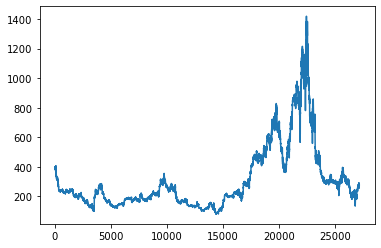

In [3]:
plt.plot(ethData['Close'])

In [4]:
prices = ethData['Close'].to_numpy()

targets = np.append(prices[1:], prices[-1])

print(prices[:5])
print(targets[:5])

print(prices.size, targets.size)

[396.12 394.97 399.52 399.68 397.69]
[394.97 399.52 399.68 397.69 392.8 ]
27149 27149


In [5]:
seq_len = 24
data=[]
for i in range(seq_len, prices.size):
    data.append((prices[i-seq_len:i], targets[i]))


In [6]:
data[55]

(array([381.65, 384.97, 384.06, 384.48, 381.31, 379.65, 383.82, 379.73,
        377.93, 372.21, 373.71, 377.74, 373.19, 379.48, 385.65, 385.04,
        382.17, 368.57, 369.17, 365.58, 359.05, 361.76, 372.67, 378.07]),
 380.3)

In [7]:
n=len(data)
train=int(0.7*n)
valid=int(0.2*n)
test=int(0.1*n)

train_data=data[:train]
valid_data=data[train:train+valid]
test_data=data[-test:]

In [8]:
#TODO: fix error when specifying larger batch size than 1 --- FIXED
batch_size=64

trainLoader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_data,batch_size = batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(test_data,batch_size = batch_size, shuffle=True)

In [9]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [23]:
class rnn_model(nn.Module):
    def __init__(self, input_size, n_hidden, n_layers, n_out):
        super().__init__()
        
        self.n_hidden=n_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, batch_first = True, dropout = 0.3)
        self.fcn1 = nn.Linear(n_hidden, 128)
        self.fcn2 = nn.Linear(128, n_out)#single value for regression
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, hidden):
        #x input shape is (batch_size, seq_len, features)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1,self.n_hidden) #reshape lstm output for fcl
        output=self.fcn1(lstm_out)
        output = self.dropout(output)
        output=self.fcn2(output)
        #sig_out = self.sig(output)
        #print(x.size(0))
        output = output.view(x.size(0),-1)
        return output[:,-1], hidden #return last prediction for each batch, and the hidden state
    
    def init_hidden(self,batch_size):
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        
rnn = rnn_model(1,64,2,1)
rnn

rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [25]:

epochs=50
counter=0
clip=5 #gradient clipping to prevent exploding gradients common in lstms
print_every=200

train_losses=[]
valid_losses=[]

if train_on_gpu:
    rnn.cuda()
    
rnn.train()
for e in range(epochs):
    #initialize hidden state
    h = rnn.init_hidden(batch_size)
    
    for inputs, labels in trainLoader:
        counter+=1
        
        #if cuda is available, push data to gpu
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
            
        #reshape inputs and convert to float
        inputs = inputs.float().unsqueeze(-1)
        #print(inputs.shape)
        #print(inputs, labels)
        #make new variables for hidden state so back propagation doesnt occur through entire hidden layer history
        h = tuple([each.data for each in h])
        
        #clear out gradients
        rnn.zero_grad()
        
        #get model output
        out, h = rnn(inputs, h)
        
        #print(out, labels.shape)
        #calc loss and perform backpropagation
        loss = criterion(out.squeeze(0),labels.float())
        loss.backward()
        
        train_losses.append(loss.item())
        
        nn.utils.clip_grad_norm_(rnn.parameters(), clip)
        optimizer.step()
        
        #every few loops, print the loss and accuracy metrics
        if counter % print_every == 0:
            val_h = rnn.init_hidden(batch_size)
            val_losses = []
            rnn.eval()
            for inputs, labels in validLoader:
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.float().unsqueeze(-1)
                val_out, val_h = rnn(inputs, val_h)
                
                val_loss = criterion(val_out.squeeze(0), labels.float())
                val_losses.append(val_loss.item())
            print('..training loss: ', round(loss.item()))
            
            print('validation loss: ', round(np.mean(val_losses)))
            valid_losses.append(np.mean(val_losses))
            rnn.train()

..training loss:  8447
validation loss:  265099
..training loss:  211
validation loss:  158083
..training loss:  170
validation loss:  102927
..training loss:  236
validation loss:  88390
..training loss:  782
validation loss:  81143
..training loss:  153
validation loss:  74182
..training loss:  206
validation loss:  69365
..training loss:  271
validation loss:  65198
..training loss:  180
validation loss:  62269
..training loss:  185
validation loss:  59513
..training loss:  215
validation loss:  57637
..training loss:  108
validation loss:  55830
..training loss:  137
validation loss:  53141
..training loss:  169
validation loss:  53383
..training loss:  124
validation loss:  51281
..training loss:  274
validation loss:  51616
..training loss:  238
validation loss:  49754
..training loss:  194
validation loss:  49112
..training loss:  176
validation loss:  48767
..training loss:  126
validation loss:  48063
..training loss:  235
validation loss:  48254
..training loss:  149
validati

best losses were 95440 for validation and 903 for training with 3 layers, 32 nodes

best losses were 53651 for validation and 410 for training with 2 layers, 64 nodes

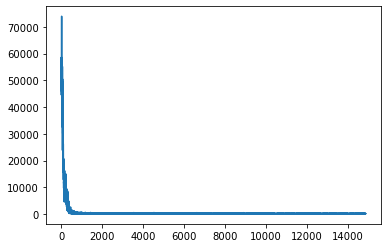

In [26]:
plt.plot(train_losses)

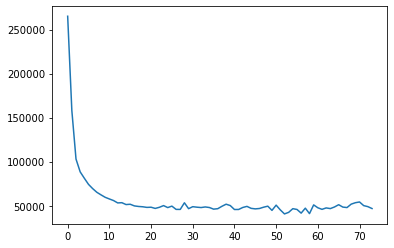

In [27]:
plt.plot(valid_losses)

In [15]:
tod = datetime.datetime.now()
test=crc.get_historical_price('ETH', 'USD',
                         timestamp=tod, exchange='Coinbase')

In [16]:
def get_past_days(num_days=5,curr='ETH'):
    tod = datetime.datetime.now()
    prices=[]
    for i in range(num_days+1,1,-1):
        d = datetime.timedelta(days = i)
        a = tod - d
        price=crc.get_historical_price(curr, 'USD',
                         timestamp=a, exchange='Coinbase')
        prices.append(price[curr]['USD'])
    return prices
p=get_past_days(seq_len + 1)
p

[239.17,
 236.1,
 245.88,
 264.28,
 275.68,
 279.59,
 305.66,
 311.35,
 322.24,
 317.59,
 318.16,
 335.31,
 346.86,
 387.4,
 372.21,
 386.22,
 389.82,
 401.21,
 395.28,
 379.75,
 397.51,
 390.41,
 395.78,
 378.88,
 387.27]

In [20]:
future = p[:]
#future.append(421.08)

#future = [393.71, 389.74, 390.87, 385.61, 380.49, 381.65, 384.97]

future = torch.Tensor(future)

In [29]:
rnn.eval()
future=future.float().view(1,-1,1)
prediction = rnn(future.cuda(), rnn.init_hidden(1))
print(prediction[0].item(), test['ETH']['USD'])
rnn.train()

374.9017333984375 423.26


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [19]:
rnn.eval()
for inputs, labels in validLoader:
    if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
            test_h = tuple([each.data for each in test_h])
            inputs = inputs.float().unsqueeze(-1)
            test_out, val_h = rnn(inputs, test_h)

            test_losses.append(test_loss.item())
rnn.train()

NameError: name 'test_h' is not defined